In [1]:
!pip install -q catboost
!pip install -q workalendar
!pip install -q pycaret
!pip install -q optuna
!pip install -q pycaret[tuners]
!pip uninstall packaging
!pip install packaging

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.4/484.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 72.4 MB/s eta 0

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as spst
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report,mean_absolute_percentage_error
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.impute import KNNImputer
from workalendar.asia import SouthKorea
cal = SouthKorea()
from catboost import CatBoostRegressor

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv("/content/drive/MyDrive/dacon/train.csv")
test = pd.read_csv("/content/drive/MyDrive/dacon/test.csv")
building_info = pd.read_csv("/content/drive/MyDrive/dacon/building_info.csv")
sample_submission = pd.read_csv("/content/drive/MyDrive/dacon/sample_submission.csv")

In [5]:
def gggg(test,building_info):
    test = test.drop(["num_date_time",'일조(hr)','일사(MJ/m2)'],axis=1)
    test["강수량(mm)"] = test["강수량(mm)"].fillna(0)

    imputer = KNNImputer(n_neighbors=5)
    imputer2 = KNNImputer(n_neighbors=5)
    test[["풍속(m/s)"]] = imputer.fit_transform(test[["풍속(m/s)"]])
    test[["습도(%)"]] = imputer2.fit_transform(test[["습도(%)"]])

    test = pd.merge(test, building_info, how = 'inner', on = '건물번호')
    # test = test.drop(['건물번호'],axis=1)

    test['일시1'] = pd.to_datetime(test['일시'])
    test['month'] = test["일시1"].dt.month
    test['day'] = test["일시1"].dt.day
    test['hour'] = test["일시1"].dt.hour
    test['강수 유무'] = np.where(test["강수량(mm)"]==0,0,1)
    test["불쾌지수"] = 9/5*test["기온(C)"]-0.55*(1-(test["습도(%)"]/100))*(9/5*test["기온(C)"]-26)+32

    test["태양광용량(kW)"] = np.where(test["태양광용량(kW)"]=='-',0,test["태양광용량(kW)"])
    test["태양광 유무"] = np.where(test["태양광용량(kW)"]==0,0,1)

    test['측정일시2'] = pd.to_datetime(test['일시1']).dt.date
    test['측정일시2'] = pd.to_datetime(test['측정일시2'])
    test['day_of_week'] = test['측정일시2'].dt.day_name()  # 요일
    test = test.rename(columns={'측정일시2':'Date'})
    holiday=pd.DataFrame(cal.holidays(2022))
    holiday=holiday.rename(columns={0:"Date",1:"holiday"})
    holiday["Date"] = pd.to_datetime(holiday["Date"])
    test = pd.merge(test,holiday,on="Date",how="left")
    test['빨간날'] = np.where((test['day_of_week']=='Sunday') | (test['day_of_week']=='Saturday') | (test['holiday'].isnull()==False),1,0)

    test = test.drop(['holiday','day_of_week','Date','일시'],axis=1)

    test['불쾌지수 단계'] = pd.cut(test['불쾌지수'], bins =[0,68, 75, 80,100] , labels = [0,1,2,3])
    test = pd.get_dummies(test, columns = ['불쾌지수 단계'],drop_first=True)
    # test = test.drop(['연면적(m2)','냉방면적(m2)'],axis=1)

    test = test.drop(["ESS저장용량(kWh)","PCS용량(kW)"],axis=1)

    return test

def test123(test,building_info):
    test = test.drop(["num_date_time"],axis=1)
    test["강수량(mm)"] = test["강수량(mm)"].fillna(0)

    imputer = KNNImputer(n_neighbors=5)
    imputer2 = KNNImputer(n_neighbors=5)
    test[["풍속(m/s)"]] = imputer.fit_transform(test[["풍속(m/s)"]])
    test[["습도(%)"]] = imputer2.fit_transform(test[["습도(%)"]])

    test = pd.merge(test, building_info, how = 'inner', on = '건물번호')
    # test = test.drop(['건물번호'],axis=1)
    test["태양광용량(kW)"] = np.where(test["태양광용량(kW)"]=='-',0,test["태양광용량(kW)"])
    test["태양광 유무"] = np.where(test["태양광용량(kW)"]==0,0,1)
    test['일시1'] = pd.to_datetime(test['일시'])
    test['month'] = test["일시1"].dt.month
    test['day'] = test["일시1"].dt.day
    test['hour'] = test["일시1"].dt.hour
    test['강수 유무'] = np.where(test["강수량(mm)"]==0,0,1)
    test["불쾌지수"] = 9/5*test["기온(C)"]-0.55*(1-(test["습도(%)"]/100))*(9/5*test["기온(C)"]-26)+32

    test['측정일시2'] = pd.to_datetime(test['일시1']).dt.date
    test['측정일시2'] = pd.to_datetime(test['측정일시2'])
    test['day_of_week'] = test['측정일시2'].dt.day_name()  # 요일
    test = test.rename(columns={'측정일시2':'Date'})
    holiday=pd.DataFrame(cal.holidays(2022))
    holiday=holiday.rename(columns={0:"Date",1:"holiday"})
    holiday["Date"] = pd.to_datetime(holiday["Date"])
    test = pd.merge(test,holiday,on="Date",how="left")
    test['빨간날'] = np.where((test['day_of_week']=='Sunday') | (test['day_of_week']=='Saturday') | (test['holiday'].isnull()==False),1,0)

    test = test.drop(['holiday','day_of_week','Date','일시'],axis=1)


    test['불쾌지수 단계'] = pd.cut(test['불쾌지수'], bins =[0,68, 75, 80,100] , labels = [0,1,2,3])
    test = pd.get_dummies(test, columns = ['불쾌지수 단계'],drop_first=True)
    # test = test.drop(['연면적(m2)','냉방면적(m2)'],axis=1)

    test = test.drop(["ESS저장용량(kWh)","PCS용량(kW)"],axis=1)

    return test

def result(sample_submission,y_pred):
    sample_submission['answer1'] = y_pred
    sample_submission = sample_submission.drop('answer',axis=1)
    sample_submission = sample_submission.rename(columns={'answer1':'answer'})
    sample_submission.to_csv('cat2.csv',index = False)

In [6]:
pd.options.display.max_columns = 50

In [7]:
train = gggg(data,building_info)
# train = train.loc[train['hour']==0]
train = train.loc[train['건물번호']==2].reset_index().drop('index',axis=1)
train = pd.get_dummies(train,columns=['건물유형'],drop_first=True)
# train = train.sort_values(['month','day','건물번호'])
train

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),전력소비량(kWh),연면적(m2),냉방면적(m2),태양광용량(kW),일시1,month,day,hour,강수 유무,불쾌지수,태양광 유무,빨간날,불쾌지수 단계_1,불쾌지수 단계_2,불쾌지수 단계_3
0,2,18.6,0.0,0.9,42.0,1170.36,122233.47,99000.0,0,2022-06-01 00:00:00,6,1,0,0,63.09388,0,0,0,0,0
1,2,18.0,0.0,1.1,45.0,1146.96,122233.47,99000.0,0,2022-06-01 01:00:00,6,1,1,0,62.46400,0,0,0,0,0
2,2,17.7,0.0,1.5,45.0,1115.28,122233.47,99000.0,0,2022-06-01 02:00:00,6,1,2,0,62.08735,0,0,0,0,0
3,2,16.7,0.0,1.4,48.0,1107.00,122233.47,99000.0,0,2022-06-01 03:00:00,6,1,3,0,60.89884,0,0,0,0,0
4,2,18.4,0.0,2.8,43.0,1069.92,122233.47,99000.0,0,2022-06-01 04:00:00,6,1,4,0,62.88788,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,2,25.5,0.0,2.9,63.0,1866.96,122233.47,99000.0,0,2022-08-24 19:00:00,8,24,19,0,73.85035,0,0,1,0,0
2036,2,25.0,0.0,2.6,66.0,1693.80,122233.47,99000.0,0,2022-08-24 20:00:00,8,24,20,0,73.44700,0,0,1,0,0
2037,2,24.6,0.0,1.3,67.0,1564.92,122233.47,99000.0,0,2022-08-24 21:00:00,8,24,21,0,72.96218,0,0,1,0,0
2038,2,24.1,0.0,2.1,70.0,948.96,122233.47,99000.0,0,2022-08-24 22:00:00,8,24,22,0,72.51230,0,0,1,0,0


In [8]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# from sklearn.linear_model import BayesianRidge

# for i in range(1,101):
#     train = gggg(data,building_info)
#     train = train.loc[train['hour']==0]
#     train = pd.get_dummies(train,columns=['건물유형'],drop_first=True)
#     train = train.sort_values(['month','day','건물번호'])
#     train = train.loc[train['건물번호']==i]
#     train['전력소비량'] = train["전력소비량(kWh)"].shift(-1)

#     bayesian_ridge_estimator = BayesianRidge()
#     imputer = IterativeImputer(max_iter = 10, random_state = 42,estimator = bayesian_ridge_estimator)
#     train['전력소비량'] = imputer.fit_transform(train[['전력소비량']])

#     train = train.drop(['일시1'],axis=1)
#     if i==1:
#         train1 = train.copy()
#         continue
#     else:
#         train1 = pd.concat([train1,train])

# display(train1)

In [9]:
train = train.drop(['일시1','건물번호','연면적(m2)','냉방면적(m2)'],axis=1)
train

,기온(C),강수량(mm),풍속(m/s),습도(%),전력소비량(kWh),태양광용량(kW),month,day,hour,강수 유무,불쾌지수,태양광 유무,빨간날,불쾌지수 단계_1,불쾌지수 단계_2,불쾌지수 단계_3
0,18.6,0.0,0.9,42.0,1170.36,0,6,1,0,0,63.09388,0,0,0,0,0
1,18.0,0.0,1.1,45.0,1146.96,0,6,1,1,0,62.46400,0,0,0,0,0
2,17.7,0.0,1.5,45.0,1115.28,0,6,1,2,0,62.08735,0,0,0,0,0
3,16.7,0.0,1.4,48.0,1107.00,0,6,1,3,0,60.89884,0,0,0,0,0
4,18.4,0.0,2.8,43.0,1069.92,0,6,1,4,0,62.88788,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,25.5,0.0,2.9,63.0,1866.96,0,8,24,19,0,73.85035,0,0,1,0,0
2036,25.0,0.0,2.6,66.0,1693.80,0,8,24,20,0,73.44700,0,0,1,0,0
2037,24.6,0.0,1.3,67.0,1564.92,0,8,24,21,0,72.96218,0,0,1,0,0
2038,24.1,0.0,2.1,70.0,948.96,0,8,24,22,0,72.51230,0,0,1,0,0


In [10]:

# firstb = train[["불쾌지수 단계_1", '불쾌지수 단계_2', '불쾌지수 단계_3','건물유형_공공','건물유형_대학교','건물유형_데이터센터','건물유형_백화점및아울렛','건물유형_병원',
#  '건물유형_상용','건물유형_아파트','건물유형_연구소','건물유형_지식산업센터','건물유형_할인마트','건물유형_호텔및리조트','전력소비량(kWh)','태양광 유무','강수 유무']]
# x_ = train.drop(["불쾌지수 단계_1", '불쾌지수 단계_2', '불쾌지수 단계_3','건물유형_공공','건물유형_대학교','건물유형_데이터센터','건물유형_백화점및아울렛','건물유형_병원',
#              '건물유형_상용','건물유형_아파트','건물유형_연구소','건물유형_지식산업센터','건물유형_할인마트','건물유형_호텔및리조트','전력소비량(kWh)','태양광 유무','강수 유무'],axis=1)
train = pd.get_dummies(train,columns=['hour'],drop_first=True)
train = train.drop(['month','day'],axis=1)
firstb = train[["불쾌지수 단계_1", '불쾌지수 단계_2', '불쾌지수 단계_3','태양광 유무','강수 유무','전력소비량(kWh)','빨간날','hour_1',	'hour_2',	'hour_3'	,'hour_4'	,'hour_5'	,'hour_6'	,'hour_7'	,'hour_8'	,'hour_9',	'hour_10'	,'hour_11'	,'hour_12'	,'hour_13'	,'hour_14'	,'hour_15'	,'hour_16',	'hour_17'	,'hour_18'	,'hour_19'	,'hour_20'	,'hour_21'	,'hour_22'	,'hour_23']]
x_ = train.drop(["불쾌지수 단계_1", '불쾌지수 단계_2', '불쾌지수 단계_3', '전력소비량(kWh)','태양광 유무','강수 유무','빨간날','hour_1',	'hour_2',	'hour_3'	,'hour_4'	,'hour_5'	,'hour_6'	,'hour_7'	,'hour_8'	,'hour_9',	'hour_10'	,'hour_11'	,'hour_12'	,'hour_13'	,'hour_14'	,'hour_15'	,'hour_16',	'hour_17'	,'hour_18'	,'hour_19'	,'hour_20'	,'hour_21'	,'hour_22'	,'hour_23'],axis=1)

scaler = StandardScaler()
scaler.fit(x_)

x_train_ = scaler.transform(x_)
x_train = pd.DataFrame(x_train_,index=x_.index,columns=x_.columns)
train = pd.concat([x_train,firstb],axis=1)
train

,기온(C),강수량(mm),풍속(m/s),습도(%),태양광용량(kW),불쾌지수,불쾌지수 단계_1,불쾌지수 단계_2,불쾌지수 단계_3,태양광 유무,강수 유무,전력소비량(kWh),빨간날,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,-2.032448,-0.192615,-1.265495,-2.516713,0.0,-2.476069,0,0,0,0,0,1170.36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-2.201384,-0.192615,-1.090018,-2.300822,0.0,-2.599674,0,0,0,0,0,1146.96,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-2.285852,-0.192615,-0.739065,-2.300822,0.0,-2.673586,0,0,0,0,0,1115.28,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-2.567412,-0.192615,-0.826804,-2.084932,0.0,-2.906815,0,0,0,0,0,1107.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-2.088760,-0.192615,0.401531,-2.444749,0.0,-2.516494,0,0,0,0,0,1069.92,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,-0.089685,-0.192615,0.489270,-1.005479,0.0,-0.365265,1,0,0,0,0,1866.96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2036,-0.230465,-0.192615,0.226055,-0.789588,0.0,-0.444417,1,0,0,0,0,1693.80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2037,-0.343089,-0.192615,-0.914542,-0.717625,0.0,-0.539556,1,0,0,0,0,1564.92,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2038,-0.483869,-0.192615,-0.212636,-0.501734,0.0,-0.627838,1,0,0,0,0,948.96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [11]:
test = pd.read_csv("/content/drive/MyDrive/dacon/test.csv")
test = test123(test,building_info)
test

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),태양광 유무,일시1,month,day,hour,강수 유무,불쾌지수,빨간날,불쾌지수 단계_1,불쾌지수 단계_2,불쾌지수 단계_3
0,1,23.5,0.0,2.2,72.0,건물기타,110634.00,39570.00,0,0,2022-08-25 00:00:00,8,25,0,0,71.78980,0,1,0,0
1,1,23.0,0.0,0.9,72.0,건물기타,110634.00,39570.00,0,0,2022-08-25 01:00:00,8,25,1,0,71.02840,0,1,0,0
2,1,22.7,0.0,1.5,75.0,건물기타,110634.00,39570.00,0,0,2022-08-25 02:00:00,8,25,2,0,70.81675,0,1,0,0
3,1,22.1,0.0,1.3,78.0,건물기타,110634.00,39570.00,0,0,2022-08-25 03:00:00,8,25,3,0,70.11262,0,1,0,0
4,1,21.8,0.0,1.0,77.0,건물기타,110634.00,39570.00,0,0,2022-08-25 04:00:00,8,25,4,0,69.56514,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,100,22.5,0.0,0.9,84.0,호텔및리조트,57497.84,40035.23,0,0,2022-08-31 19:00:00,8,31,19,0,71.22400,0,1,0,0
16796,100,20.7,0.0,0.4,95.0,호텔및리조트,57497.84,40035.23,0,0,2022-08-31 20:00:00,8,31,20,0,68.95035,0,1,0,0
16797,100,20.2,0.0,0.4,98.0,호텔및리조트,57497.84,40035.23,0,0,2022-08-31 21:00:00,8,31,21,0,68.24604,0,1,0,0
16798,100,20.1,0.0,1.1,97.0,호텔및리조트,57497.84,40035.23,0,0,2022-08-31 22:00:00,8,31,22,0,68.01203,0,1,0,0


In [12]:
# test = pd.get_dummies(test,columns=['건물유형'],drop_first=True)
# test = test.sort_values(['month','day','건물번호'])
test = test.drop(['일시1','건물유형'],axis=1)
test

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),연면적(m2),냉방면적(m2),태양광용량(kW),태양광 유무,month,day,hour,강수 유무,불쾌지수,빨간날,불쾌지수 단계_1,불쾌지수 단계_2,불쾌지수 단계_3
0,1,23.5,0.0,2.2,72.0,110634.00,39570.00,0,0,8,25,0,0,71.78980,0,1,0,0
1,1,23.0,0.0,0.9,72.0,110634.00,39570.00,0,0,8,25,1,0,71.02840,0,1,0,0
2,1,22.7,0.0,1.5,75.0,110634.00,39570.00,0,0,8,25,2,0,70.81675,0,1,0,0
3,1,22.1,0.0,1.3,78.0,110634.00,39570.00,0,0,8,25,3,0,70.11262,0,1,0,0
4,1,21.8,0.0,1.0,77.0,110634.00,39570.00,0,0,8,25,4,0,69.56514,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,100,22.5,0.0,0.9,84.0,57497.84,40035.23,0,0,8,31,19,0,71.22400,0,1,0,0
16796,100,20.7,0.0,0.4,95.0,57497.84,40035.23,0,0,8,31,20,0,68.95035,0,1,0,0
16797,100,20.2,0.0,0.4,98.0,57497.84,40035.23,0,0,8,31,21,0,68.24604,0,1,0,0
16798,100,20.1,0.0,1.1,97.0,57497.84,40035.23,0,0,8,31,22,0,68.01203,0,1,0,0


In [13]:
test['태양광 유무'].value_counts()

0    10752
1     6048
Name: 태양광 유무, dtype: int64

In [14]:
# firstbbb = test[["불쾌지수 단계_1", '불쾌지수 단계_2', '불쾌지수 단계_3','건물유형_공공','건물유형_대학교','건물유형_데이터센터','건물유형_백화점및아울렛','건물유형_병원',
#  '건물유형_상용','건물유형_아파트','건물유형_연구소','건물유형_지식산업센터','건물유형_할인마트','건물유형_호텔및리조트','태양광 유무','강수 유무']]
# x___ = test.drop(["불쾌지수 단계_1", '불쾌지수 단계_2', '불쾌지수 단계_3','건물유형_공공','건물유형_대학교','건물유형_데이터센터','건물유형_백화점및아울렛','건물유형_병원',
#              '건물유형_상용','건물유형_아파트','건물유형_연구소','건물유형_지식산업센터','건물유형_할인마트','건물유형_호텔및리조트','태양광 유무','강수 유무'],axis=1)

test = test.loc[test['건물번호']==1]
test = pd.get_dummies(test,columns=['hour'],drop_first=True)
firstbbb = test[["불쾌지수 단계_1", '불쾌지수 단계_2', '불쾌지수 단계_3','태양광 유무','강수 유무','빨간날','hour_1',	'hour_2',	'hour_3'	,'hour_4'	,'hour_5'	,'hour_6'	,'hour_7'	,'hour_8'	,'hour_9',	'hour_10'	,'hour_11'	,'hour_12'	,'hour_13'	,'hour_14'	,'hour_15'	,'hour_16',	'hour_17'	,'hour_18'	,'hour_19'	,'hour_20'	,'hour_21'	,'hour_22'	,'hour_23']]
x___ = test.drop(["불쾌지수 단계_1", '불쾌지수 단계_2', '불쾌지수 단계_3','태양광 유무','강수 유무','빨간날','hour_1',	'hour_2',	'hour_3'	,'hour_4'	,'hour_5'	,'hour_6'	,'hour_7'	,'hour_8'	,'hour_9',	'hour_10'	,'hour_11'	,'hour_12'	,'hour_13'	,'hour_14'	,'hour_15'	,'hour_16',	'hour_17'	,'hour_18'	,'hour_19'	,'hour_20'	,'hour_21'	,'hour_22'	,'hour_23'],axis=1)

scaler1 = StandardScaler()
scaler1.fit(x___)
x_test = scaler1.transform(x___)
x_test = pd.DataFrame(x_test,index=x___.index,columns=x___.columns)
test = pd.concat([x_test,firstbbb],axis=1)
test = test.drop(['건물번호','month','day','연면적(m2)','냉방면적(m2)'],axis=1)
test

,기온(C),강수량(mm),풍속(m/s),습도(%),태양광용량(kW),불쾌지수,불쾌지수 단계_1,불쾌지수 단계_2,불쾌지수 단계_3,태양광 유무,강수 유무,빨간날,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0.703128,-0.248065,-0.000698,-0.246328,0.0,0.860970,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.506710,-0.248065,-1.524409,-0.246328,0.0,0.620131,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.388860,-0.248065,-0.821157,-0.049266,0.0,0.553184,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.153159,-0.248065,-1.055575,0.147797,0.0,0.330461,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.035308,-0.248065,-1.407200,0.082109,0.0,0.157288,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.703128,-0.248065,-0.235115,-0.049266,0.0,0.946041,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
164,0.271009,-0.248065,-0.235115,0.279171,0.0,0.530426,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
165,-0.003975,-0.248065,-0.703949,0.344859,0.0,0.198436,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
166,-0.239676,-0.248065,-1.407200,0.476233,0.0,-0.065796,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
from pycaret.regression import *
s = setup(train, target = '전력소비량(kWh)', session_id = 42,fold=5,use_gpu=True)

,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(8500, 26)"
4,Transformed data shape,"(8500, 26)"
5,Transformed train set shape,"(5950, 26)"
6,Transformed test set shape,"(2550, 26)"
7,Numeric features,25
8,Preprocess,True
9,Imputation type,simple


In [ ]:
best = compare_models(sort='MAPE', n_select=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,81.9413,19513.4333,139.5584,0.9956,0.0935,0.0595,3.5300
et,Extra Trees Regressor,84.0818,20014.0998,141.3818,0.9955,0.1024,0.0641,2.7780
knn,K Neighbors Regressor,98.9162,29130.8031,170.3487,0.9934,0.1113,0.0716,0.1120
dt,Decision Tree Regressor,102.5503,32934.6850,180.8946,0.9926,0.1197,0.0744,0.1200
lightgbm,Light Gradient Boosting Machine,95.3998,20995.5891,144.7705,0.9953,0.1121,0.0781,1.0580
gbr,Gradient Boosting Regressor,252.8367,108419.3784,328.8612,0.9755,0.2662,0.2272,0.9580
lasso,Lasso Regression,949.5835,2721799.4000,1646.9396,0.3868,0.6323,0.6384,0.4220
ridge,Ridge Regression,955.6091,2721542.4500,1646.9394,0.3868,0.6628,0.6448,0.1980
br,Bayesian Ridge,955.3184,2721441.3500,1646.9244,0.3868,0.6645,0.6450,0.1800
llar,Lasso Least Angle Regression,955.9874,2721222.4000,1646.8317,0.3869,0.6567,0.6459,0.1260


Processing:   0%|          | 0/89 [00:00<?, ?it/s]

In [ ]:
# tuned_top5 = [tune_model(i) for i in best]

In [ ]:
blender_top5 = blend_models(estimator_list=best)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,80.1697,17783.0329,133.3530,0.9961,0.0940,0.0602
1,80.5444,17603.9184,132.6798,0.9959,0.0944,0.0618
2,78.1242,17008.2425,130.4157,0.9957,0.0889,0.0581
3,86.9465,22659.0996,150.5294,0.9955,0.0972,0.0628
4,80.2296,17154.3880,130.9748,0.9960,0.0920,0.0606
Mean,81.2029,18441.7363,135.5905,0.9958,0.0933,0.0607
Std,2.9972,2127.6349,7.5463,0.0002,0.0028,0.0016


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
final_best = finalize_model(blender)
prediction = predict_model(final_best, data = test)

In [ ]:
prediction = predict_model(final_best, data = test.loc[test['hour']==0])

In [ ]:
prediction

,기온(C),강수량(mm),풍속(m/s),습도(%),연면적(m2),냉방면적(m2),month,day,hour,강수 유무,...,건물유형_데이터센터,건물유형_백화점및아울렛,건물유형_병원,건물유형_상용,건물유형_아파트,건물유형_연구소,건물유형_지식산업센터,건물유형_할인마트,건물유형_호텔및리조트,prediction_label
0,23.500000,0.0,2.2,72.0,110634.000000,39570.000000,8,25,0,0,...,0,0,0,0,0,0,0,0,0,2012.720960
168,23.500000,0.0,2.2,72.0,122233.468750,99000.000000,8,25,0,0,...,0,0,0,0,0,0,0,0,0,1257.264270
336,23.500000,0.0,2.2,72.0,171243.000000,113950.000000,8,25,0,0,...,0,0,0,0,0,0,0,0,0,1070.998077
504,23.500000,0.0,2.2,72.0,74312.976562,34419.621094,8,25,0,0,...,0,0,0,0,0,0,0,0,0,733.443919
672,23.500000,0.0,2.2,72.0,205884.000000,150000.000000,8,25,0,0,...,0,0,0,0,0,0,0,0,0,1884.004882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16104,23.400000,0.0,1.4,96.0,93314.000000,60500.000000,8,31,0,0,...,0,0,0,0,0,0,0,0,1,2206.610891
16272,27.000000,0.0,2.1,67.0,55144.671875,25880.000000,8,31,0,0,...,0,0,0,0,0,0,0,0,1,863.363771
16440,20.799999,0.0,0.8,97.0,53578.621094,17373.750000,8,31,0,0,...,0,0,0,0,0,0,0,0,1,584.013102
16608,18.900000,2.3,2.1,97.0,53499.000000,40636.000000,8,31,0,1,...,0,0,0,0,0,0,0,0,1,684.738546


In [ ]:
result0 = prediction['prediction_label'].values

In [ ]:
train = gggg(data,building_info)
train = train.loc[train['hour']==23]
# train = train.loc[train['건물번호']==1]
train = pd.get_dummies(train,columns=['건물유형'],drop_first=True)
# train = train.sort_values(['month','day','건물번호'])
train = train.drop(['일시1','건물번호','hour'],axis=1)

firstb = train[["불쾌지수 단계_1", '불쾌지수 단계_2', '불쾌지수 단계_3','건물유형_공공','건물유형_대학교','건물유형_데이터센터','건물유형_백화점및아울렛','건물유형_병원',
 '건물유형_상용','건물유형_아파트','건물유형_연구소','건물유형_지식산업센터','건물유형_할인마트','건물유형_호텔및리조트','전력소비량(kWh)']]
x_ = train.drop(["불쾌지수 단계_1", '불쾌지수 단계_2', '불쾌지수 단계_3','건물유형_공공','건물유형_대학교','건물유형_데이터센터','건물유형_백화점및아울렛','건물유형_병원',
             '건물유형_상용','건물유형_아파트','건물유형_연구소','건물유형_지식산업센터','건물유형_할인마트','건물유형_호텔및리조트','전력소비량(kWh)'],axis=1)

scaler = StandardScaler()
scaler.fit(x_)
x_train_ = scaler.transform(x_)
x_train = pd.DataFrame(x_train_,index=x_.index,columns=x_.columns)
train = pd.concat([x_train,firstb],axis=1)


s = setup(train, target = '전력소비량(kWh)', session_id = 42,fold=5,use_gpu=True)
best = compare_models(sort='MAPE', n_select=4)
blender_top5 = blend_models(estimator_list=best,optimize = 'MAPE')
final_best = finalize_model(blender_top5)
test1 = test.loc[test['hour']==23]
test1 = test1.drop('hour',axis=1)
prediction = predict_model(final_best, data = test1)
result23 = prediction['prediction_label'].values

,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(8500, 26)"
4,Transformed data shape,"(8500, 26)"
5,Transformed train set shape,"(5950, 26)"
6,Transformed test set shape,"(2550, 26)"
7,Numeric features,25
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,86.2910,21648.3536,146.9314,0.9952,0.0957,0.0606,3.5760
et,Extra Trees Regressor,88.7108,22775.0976,150.6549,0.9950,0.1061,0.0662,2.7240
dt,Decision Tree Regressor,108.2200,35042.1634,187.0416,0.9922,0.1275,0.0772,0.1280
lightgbm,Light Gradient Boosting Machine,100.0979,23339.6475,152.2390,0.9949,0.1141,0.0787,1.4840
gbr,Gradient Boosting Regressor,253.9722,114495.8487,337.7984,0.9745,0.2543,0.2104,1.0660
par,Passive Aggressive Regressor,883.2803,3702312.4835,1922.0809,0.1798,0.5612,0.3961,0.1520
huber,Huber Regressor,882.2571,3535527.6633,1877.9152,0.2174,0.5473,0.4281,0.3460
knn,K Neighbors Regressor,1007.2766,3522866.0500,1874.9998,0.2184,0.6246,0.6048,0.1180
lasso,Lasso Regression,971.7680,2807293.6000,1672.5584,0.3793,0.5941,0.6051,0.2140
br,Bayesian Ridge,974.8511,2804055.5500,1671.6290,0.3800,0.5981,0.6069,0.2760


Processing:   0%|          | 0/88 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,81.1604,16909.6687,130.0372,0.9960,0.0941,0.0610
1,87.9002,23127.9582,152.0788,0.9953,0.0996,0.0627
2,88.6596,23272.3356,152.5527,0.9955,0.1014,0.0659
3,83.9041,18516.9204,136.0769,0.9957,0.0953,0.0621
4,80.5623,17565.6998,132.5357,0.9956,0.0955,0.0599
Mean,84.4373,19878.5165,140.6562,0.9956,0.0972,0.0623
Std,3.3424,2760.2174,9.7127,0.0002,0.0028,0.0020


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
aa=[]
for i in range(700):
    aa.append(result0[i])
    aa.append(result1[i])
    aa.append(result2[i])
    aa.append(result3[i])
    aa.append(result4[i])
    aa.append(result5[i])
    aa.append(result6[i])
    aa.append(result7[i])
    aa.append(result8[i])
    aa.append(result9[i])
    aa.append(result10[i])
    aa.append(result11[i])
    aa.append(result12[i])
    aa.append(result13[i])
    aa.append(result14[i])
    aa.append(result15[i])
    aa.append(result16[i])
    aa.append(result17[i])
    aa.append(result18[i])
    aa.append(result19[i])
    aa.append(result20[i])
    aa.append(result21[i])
    aa.append(result22[i])
    aa.append(result23[i])

In [ ]:
aa

[1661.1053720096866,
 1454.422269582869,
 1533.6776667229233,
 1373.9428136432557,
 1262.07017909962,
 1546.2089894479966,
 1797.3547328506118,
 2277.296869164783,
 2851.816288055369,
 3283.631971161807,
 4008.4521837103125,
 4023.6754364366375,
 4309.412170916648,
 4156.275511231772,
 4105.850732867443,
 3889.745183816065,
 3967.6727585435247,
 3501.169227697198,
 2825.94790363223,
 2646.224468283749,
 2488.970210727198,
 2066.742489058338,
 1478.1899386384005,
 1790.0804196347435,
 1230.4119517278205,
 1193.6058544795583,
 1201.2932218654937,
 1180.3360340774377,
 1156.9716621905568,
 1151.3327684894043,
 1169.1544536594338,
 1034.8777307300672,
 1589.5603297673592,
 1769.3227683528157,
 2078.2884026295806,
 2228.579391641225,
 1717.0905741956358,
 2206.202045297904,
 2482.003059836162,
 2376.715895198372,
 2432.5671107265216,
 2497.7558566183643,
 2558.09858220963,
 2256.812853104386,
 2195.6931258416366,
 1942.9835151603181,
 1169.818716078409,
 1265.8249056905665,
 988.29106766166

In [ ]:
result(sample_submission,aa)

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import random
import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import accuracy_score

In [ ]:
x = train.drop('전력소비량(kWh)',axis=1)
y = train[['전력소비량(kWh)']]

In [ ]:
def objective(trial):
  param = {
      "random_state":42,
      'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.1),
      'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.1, 10),
      "n_estimators":trial.suggest_int("n_estimators", 100, 1000),
      "max_depth":trial.suggest_int("max_depth", 4, 16),
      'random_strength' :trial.suggest_int('random_strength', 0, 100),
      "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
      "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
      "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
      "max_bin": trial.suggest_int("max_bin", 50, 250),
      'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
  }

  x_train, x_valid, y_train, y_valid = train_test_split(x,y,test_size=0.2)

  cat = CatBoostRegressor(**param)
  cat.fit(x_train, y_train,
          eval_set=[(x_train, y_train), (x_valid,y_valid)],
          early_stopping_rounds=50,verbose=100)
  cat_pred = cat.predict(x_valid)
  mape = mean_absolute_percentage_error(y_valid, cat_pred)

  return mape

In [ ]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name = 'cat_parameter_opt',
    direction = 'minimize',
    sampler = sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:",study.best_value)
print("Best trial",study.best_trial.params)

<ipython-input-234-2ce0a10ac9ac>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-234-2ce0a10ac9ac>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.1, 10),


0:	learn: 2078.9965448	test: 2078.9965448	test1: 2181.0696138	best: 2181.0696138 (0)	total: 79.6ms	remaining: 1m
100:	learn: 1662.9304276	test: 1662.9304276	test1: 1739.7480644	best: 1739.7480644 (100)	total: 2.08s	remaining: 13.6s
200:	learn: 1398.1359922	test: 1398.1359922	test1: 1468.7765955	best: 1468.7765955 (200)	total: 3.24s	remaining: 9s
300:	learn: 1209.6904176	test: 1209.6904176	test1: 1279.0932813	best: 1279.0932813 (300)	total: 4.29s	remaining: 6.53s
400:	learn: 1080.5656924	test: 1080.5656924	test1: 1151.9430793	best: 1151.9430793 (400)	total: 5.27s	remaining: 4.7s
500:	learn: 989.9568295	test: 989.9568295	test1: 1065.0463820	best: 1065.0463820 (500)	total: 6.22s	remaining: 3.2s
600:	learn: 909.1462272	test: 909.1462272	test1: 987.0937321	best: 987.0937321 (600)	total: 7.12s	remaining: 1.87s
700:	learn: 835.9545429	test: 835.9545429	test1: 918.6931493	best: 918.6931493 (700)	total: 8.18s	remaining: 676ms
758:	learn: 798.1876877	test: 798.1876877	test1: 881.8117833	best: 88

<ipython-input-234-2ce0a10ac9ac>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-234-2ce0a10ac9ac>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.1, 10),


0:	learn: 2048.2538756	test: 2048.2538756	test1: 2112.8094964	best: 2112.8094964 (0)	total: 1.83ms	remaining: 530ms
100:	learn: 782.8449962	test: 782.8449962	test1: 822.2475043	best: 822.2475043 (100)	total: 189ms	remaining: 355ms
200:	learn: 261.9665751	test: 261.9665751	test1: 282.9503102	best: 282.9503102 (200)	total: 383ms	remaining: 172ms
290:	learn: 176.8847930	test: 176.8847930	test1: 202.9373949	best: 202.9373949 (290)	total: 571ms	remaining: 0us

bestTest = 202.9373949
bestIteration = 290



<ipython-input-234-2ce0a10ac9ac>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-234-2ce0a10ac9ac>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.1, 10),


0:	learn: 2078.8106781	test: 2078.8106781	test1: 2186.0385934	best: 2186.0385934 (0)	total: 17.1ms	remaining: 8.68s
100:	learn: 1778.9905663	test: 1778.9905663	test1: 1898.9786337	best: 1898.9786337 (100)	total: 12s	remaining: 48.4s
200:	learn: 1555.1969128	test: 1555.1969128	test1: 1686.8499143	best: 1686.8499143 (200)	total: 19.1s	remaining: 29.4s
300:	learn: 1379.5149625	test: 1379.5149625	test1: 1518.6715795	best: 1518.6715795 (300)	total: 31.1s	remaining: 21.6s
400:	learn: 1254.6403033	test: 1254.6403033	test1: 1400.3444302	best: 1400.3444302 (400)	total: 38.7s	remaining: 10.5s
500:	learn: 1160.9191461	test: 1160.9191461	test1: 1311.6641180	best: 1311.6641180 (500)	total: 49.6s	remaining: 890ms
509:	learn: 1151.7891873	test: 1151.7891873	test1: 1303.0870335	best: 1303.0870335 (509)	total: 50.3s	remaining: 0us

bestTest = 1303.087034
bestIteration = 509



<ipython-input-234-2ce0a10ac9ac>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-234-2ce0a10ac9ac>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.1, 10),


0:	learn: 2010.7505951	test: 2010.7505951	test1: 1869.2776135	best: 1869.2776135 (0)	total: 2.57ms	remaining: 2.13s
100:	learn: 520.3239828	test: 520.3239828	test1: 533.7704869	best: 533.7704869 (100)	total: 276ms	remaining: 1.99s
200:	learn: 209.0566256	test: 209.0566256	test1: 235.3756199	best: 235.3756199 (200)	total: 554ms	remaining: 1.73s
300:	learn: 141.6324982	test: 141.6324982	test1: 179.0628877	best: 179.0628877 (300)	total: 841ms	remaining: 1.47s
400:	learn: 115.7715280	test: 115.7715280	test1: 162.7098826	best: 162.7098826 (400)	total: 1.13s	remaining: 1.21s
500:	learn: 100.5827896	test: 100.5827896	test1: 156.2645443	best: 156.2645443 (500)	total: 1.41s	remaining: 919ms
600:	learn: 89.3811900	test: 89.3811900	test1: 152.8773081	best: 152.8424950 (596)	total: 1.68s	remaining: 634ms
700:	learn: 80.8557643	test: 80.8557643	test1: 151.7016215	best: 151.6413220 (695)	total: 1.96s	remaining: 355ms
800:	learn: 74.0800310	test: 74.0800310	test1: 150.7010232	best: 150.6432371 (796)	

<ipython-input-234-2ce0a10ac9ac>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-234-2ce0a10ac9ac>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.1, 10),


100:	learn: 1982.7517825	test: 1982.7517825	test1: 1893.0660940	best: 1893.0660940 (100)	total: 664ms	remaining: 1.83s
200:	learn: 1866.4102465	test: 1866.4102465	test1: 1786.3841628	best: 1786.3841628 (200)	total: 1.28s	remaining: 1.14s
300:	learn: 1769.1137323	test: 1769.1137323	test1: 1696.4838702	best: 1696.4838702 (300)	total: 1.93s	remaining: 505ms
379:	learn: 1709.2723568	test: 1709.2723568	test1: 1642.3167327	best: 1642.3167327 (379)	total: 2.38s	remaining: 0us

bestTest = 1642.316733
bestIteration = 379

0:	learn: 2119.2722118	test: 2119.2722118	test1: 1941.9575058	best: 1941.9575058 (0)	total: 1.41ms	remaining: 388ms


<ipython-input-234-2ce0a10ac9ac>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-234-2ce0a10ac9ac>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.1, 10),


100:	learn: 1351.5386664	test: 1351.5386664	test1: 1279.0483748	best: 1279.0483748 (100)	total: 154ms	remaining: 267ms
200:	learn: 530.5959423	test: 530.5959423	test1: 543.4878459	best: 543.4878459 (200)	total: 289ms	remaining: 108ms
275:	learn: 344.9277240	test: 344.9277240	test1: 367.9917709	best: 367.9917709 (275)	total: 396ms	remaining: 0us

bestTest = 367.9917709
bestIteration = 275



<ipython-input-234-2ce0a10ac9ac>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-234-2ce0a10ac9ac>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.1, 10),


0:	learn: 2108.4559654	test: 2108.4559654	test1: 2081.4207325	best: 2081.4207325 (0)	total: 394ms	remaining: 1m 5s
100:	learn: 2025.5207919	test: 2025.5207919	test1: 2011.5503323	best: 2011.5503323 (100)	total: 24.6s	remaining: 16.1s
166:	learn: 1969.3339920	test: 1969.3339920	test1: 1963.4585717	best: 1963.4585717 (166)	total: 42s	remaining: 0us

bestTest = 1963.458572
bestIteration = 166



<ipython-input-234-2ce0a10ac9ac>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-234-2ce0a10ac9ac>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.1, 10),


0:	learn: 2106.6298475	test: 2106.6298475	test1: 2098.0275034	best: 2098.0275034 (0)	total: 2.04ms	remaining: 415ms
100:	learn: 2034.8185998	test: 2034.8185998	test1: 2037.9023953	best: 2037.9023953 (100)	total: 12.4s	remaining: 12.7s
200:	learn: 1963.6675050	test: 1963.6675050	test1: 1978.2110443	best: 1978.2110443 (200)	total: 23.6s	remaining: 353ms
203:	learn: 1962.1640067	test: 1962.1640067	test1: 1976.9732719	best: 1976.9732719 (203)	total: 23.9s	remaining: 0us

bestTest = 1976.973272
bestIteration = 203



<ipython-input-234-2ce0a10ac9ac>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-234-2ce0a10ac9ac>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.1, 10),


0:	learn: 2014.6186452	test: 2014.6186452	test1: 2075.3011120	best: 2075.3011120 (0)	total: 92.9ms	remaining: 19.1s
100:	learn: 1004.7038414	test: 1004.7038414	test1: 1197.9740223	best: 1197.9740223 (100)	total: 5.34s	remaining: 5.6s
200:	learn: 502.5852613	test: 502.5852613	test1: 758.6159244	best: 758.6159244 (200)	total: 9.28s	remaining: 277ms
206:	learn: 454.3579477	test: 454.3579477	test1: 710.0693332	best: 710.0693332 (206)	total: 9.6s	remaining: 0us

bestTest = 710.0693332
bestIteration = 206

0:	learn: 2102.1849369	test: 2102.1849369	test1: 2110.5496135	best: 2110.5496135 (0)	total: 4.45ms	remaining: 2.99s


<ipython-input-234-2ce0a10ac9ac>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-234-2ce0a10ac9ac>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.1, 10),


100:	learn: 2038.6451955	test: 2038.6451955	test1: 2051.7239161	best: 2051.7239161 (100)	total: 430ms	remaining: 2.44s
200:	learn: 1981.6156187	test: 1981.6156187	test1: 1998.3664945	best: 1998.3664945 (200)	total: 854ms	remaining: 2s
300:	learn: 1930.1258069	test: 1930.1258069	test1: 1950.1312600	best: 1950.1312600 (300)	total: 1.26s	remaining: 1.55s
400:	learn: 1877.6244859	test: 1877.6244859	test1: 1901.2548802	best: 1901.2548802 (400)	total: 1.68s	remaining: 1.14s
500:	learn: 1834.9109310	test: 1834.9109310	test1: 1862.0137472	best: 1862.0137472 (500)	total: 2.09s	remaining: 717ms
600:	learn: 1796.5302126	test: 1796.5302126	test1: 1826.4693593	best: 1826.4693593 (600)	total: 2.49s	remaining: 298ms
672:	learn: 1771.3127958	test: 1771.3127958	test1: 1803.3887437	best: 1803.3887437 (672)	total: 2.79s	remaining: 0us

bestTest = 1803.388744
bestIteration = 672

Best Score: 0.07528557174815079
Best trial {'learning_rate': 0.07902619549708234, 'bagging_temperature': 8.536189862866832, 'n_

In [ ]:
study.best_params

{'learning_rate': 0.07902619549708234,
 'bagging_temperature': 8.536189862866832,
 'n_estimators': 828,
 'max_depth': 7,
 'random_strength': 9,
 'colsample_bylevel': 0.8105398159072941,
 'l2_leaf_reg': 1.3210173287250643e-05,
 'min_child_samples': 16,
 'max_bin': 149,
 'od_type': 'Iter'}

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

In [ ]:
skf = KFold(n_splits=5, shuffle=True, random_state=42)
folds = []
for train_idx, valid_idx in skf.split(x,y):
  folds.append((train_idx,valid_idx))

In [ ]:
random.seed(42)
cat_models={}


for fold in range(5):
  print(f'===================================={fold+1}============================================')
  train_idx, valid_idx = folds[fold]
  X_train = x.iloc[train_idx].values
  X_valid = x.iloc[valid_idx].values
  y_train = y.iloc[train_idx].values
  y_valid = y.iloc[valid_idx].values

  cat = CatBoostRegressor(**study.best_params)
  cat.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_valid,y_valid)],
          early_stopping_rounds=35,verbose=100)
  cat_models[fold] = cat
  print(f'================================================================================\n\n')

====================================1============================================
0:	learn: 2029.5648095	test: 2029.5648095	test1: 2188.4661405	best: 2188.4661405 (0)	total: 9.05ms	remaining: 7.49s
100:	learn: 522.0364945	test: 522.0364945	test1: 588.8719800	best: 588.8719800 (100)	total: 716ms	remaining: 5.15s
200:	learn: 219.7944205	test: 219.7944205	test1: 268.5258052	best: 268.5258052 (200)	total: 1.47s	remaining: 4.57s
300:	learn: 145.0505580	test: 145.0505580	test1: 192.0889089	best: 192.0889089 (300)	total: 2.24s	remaining: 3.93s
400:	learn: 118.9294076	test: 118.9294076	test1: 172.7418412	best: 172.7418412 (400)	total: 3.06s	remaining: 3.26s
500:	learn: 101.8686515	test: 101.8686515	test1: 163.1485778	best: 163.1485778 (500)	total: 3.83s	remaining: 2.5s
600:	learn: 90.8927018	test: 90.8927018	test1: 159.6546705	best: 159.6546705 (600)	total: 4.61s	remaining: 1.74s
700:	learn: 82.7731656	test: 82.7731656	test1: 157.8179974	best: 157.8179974 (700)	total: 5.41s	remaining: 980ms
80

In [ ]:
y.iloc[valid_idx]

,전력소비량(kWh)
72,1203.84
96,963.36
120,1108.32
216,1161.60
912,2081.28
...,...
203328,464.64
203544,573.12
203568,576.48
203640,474.00


In [ ]:
train_idx[:10],valid_idx[:10]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10]),
 array([ 8, 17, 19, 23, 26, 31, 33, 37, 41, 48]))

In [ ]:
for fold in range(5):
    if fold==0:
        y_pred = cat_models[fold].predict(test)/5
    elif fold==1:
        y_pred1 = cat_models[fold].predict(test)/5
    elif fold==2:
        y_pred2 = cat_models[fold].predict(test)/5
    elif fold==3:
        y_pred3 = cat_models[fold].predict(test)/5
    elif fold==4:
        y_pred4 = cat_models[fold].predict(test)/5


y_pred = y_pred + y_pred1 + y_pred2 + y_pred3 + y_pred4
y_pred

array([1838.17678167, 1784.914813  , 1816.36983378, ...,  502.75911974,
        493.73835334,  466.72420507])

In [ ]:
result0 = y_pred

In [ ]:
train = gggg(data,building_info)
train = train.loc[train['hour']==23]
# train = train.loc[train['건물번호']==1]
train = pd.get_dummies(train,columns=['건물유형'],drop_first=True)
# train = train.sort_values(['month','day','건물번호'])
train = train.drop(['일시1','건물번호','hour'],axis=1)

firstb = train[["불쾌지수 단계_1", '불쾌지수 단계_2', '불쾌지수 단계_3','건물유형_공공','건물유형_대학교','건물유형_데이터센터','건물유형_백화점및아울렛','건물유형_병원',
 '건물유형_상용','건물유형_아파트','건물유형_연구소','건물유형_지식산업센터','건물유형_할인마트','건물유형_호텔및리조트','전력소비량(kWh)']]
x_ = train.drop(["불쾌지수 단계_1", '불쾌지수 단계_2', '불쾌지수 단계_3','건물유형_공공','건물유형_대학교','건물유형_데이터센터','건물유형_백화점및아울렛','건물유형_병원',
             '건물유형_상용','건물유형_아파트','건물유형_연구소','건물유형_지식산업센터','건물유형_할인마트','건물유형_호텔및리조트','전력소비량(kWh)'],axis=1)

scaler = StandardScaler()
scaler.fit(x_)
x_train_ = scaler.transform(x_)
x_train = pd.DataFrame(x_train_,index=x_.index,columns=x_.columns)
train = pd.concat([x_train,firstb],axis=1)

x = train.drop('전력소비량(kWh)',axis=1)
y = train[['전력소비량(kWh)']]

sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name = 'cat_parameter_opt',
    direction = 'minimize',
    sampler = sampler,
)
study.optimize(objective, n_trials=10)
# print("Best Score:",study.best_value)
# print("Best trial",study.best_trial.params)

skf = KFold(n_splits=5, shuffle=True, random_state=42)
folds = []
for train_idx, valid_idx in skf.split(x,y):
  folds.append((train_idx,valid_idx))

random.seed(42)
cat_models={}


test1 = test.loc[test['hour']==23]
test1 = test1.drop('hour',axis=1)

for fold in range(5):
  print(f'===================================={fold+1}============================================')
  train_idx, valid_idx = folds[fold]
  X_train = x.iloc[train_idx].values
  X_valid = x.iloc[valid_idx].values
  y_train = y.iloc[train_idx].values
  y_valid = y.iloc[valid_idx].values

  cat = CatBoostRegressor(**study.best_params)
  cat.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_valid,y_valid)],
          early_stopping_rounds=35,verbose=100)
  cat_models[fold] = cat
  print(f'================================================================================\n\n')

for fold in range(5):
    if fold==0:
        y_pred = cat_models[fold].predict(test1)/5
    elif fold==1:
        y_pred1 = cat_models[fold].predict(test1)/5
    elif fold==2:
        y_pred2 = cat_models[fold].predict(test1)/5
    elif fold==3:
        y_pred3 = cat_models[fold].predict(test1)/5
    elif fold==4:
        y_pred4 = cat_models[fold].predict(test1)/5


y_pred = y_pred + y_pred1 + y_pred2 + y_pred3 + y_pred4
result23 = y_pred

<ipython-input-234-2ce0a10ac9ac>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-234-2ce0a10ac9ac>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.1, 10),


0:	learn: 2122.8390078	test: 2122.8390078	test1: 2158.1167083	best: 2158.1167083 (0)	total: 15.7ms	remaining: 11.9s
100:	learn: 1693.1511577	test: 1693.1511577	test1: 1728.9972837	best: 1728.9972837 (100)	total: 1.09s	remaining: 7.08s
200:	learn: 1411.5847929	test: 1411.5847929	test1: 1460.6618386	best: 1460.6618386 (200)	total: 2.09s	remaining: 5.8s
300:	learn: 1227.0910176	test: 1227.0910176	test1: 1288.4713827	best: 1288.4713827 (300)	total: 3.06s	remaining: 4.66s
400:	learn: 1097.3929371	test: 1097.3929371	test1: 1171.0209070	best: 1171.0209070 (400)	total: 4s	remaining: 3.57s
500:	learn: 995.1956838	test: 995.1956838	test1: 1078.0737936	best: 1078.0737936 (500)	total: 5.42s	remaining: 2.79s
600:	learn: 913.9798645	test: 913.9798645	test1: 1004.9605611	best: 1004.9605611 (600)	total: 7.48s	remaining: 1.97s
700:	learn: 848.6236868	test: 848.6236868	test1: 946.9193228	best: 946.9193228 (700)	total: 9.43s	remaining: 780ms
758:	learn: 809.6445656	test: 809.6445656	test1: 910.3183354	be

<ipython-input-234-2ce0a10ac9ac>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-234-2ce0a10ac9ac>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.1, 10),


0:	learn: 2069.2123616	test: 2069.2123616	test1: 2155.7375632	best: 2155.7375632 (0)	total: 12.5ms	remaining: 3.63s
100:	learn: 768.9752253	test: 768.9752253	test1: 806.4023958	best: 806.4023958 (100)	total: 544ms	remaining: 1.02s
200:	learn: 264.7867137	test: 264.7867137	test1: 284.4238919	best: 284.4238919 (200)	total: 1.09s	remaining: 490ms
290:	learn: 181.2675830	test: 181.2675830	test1: 202.0036636	best: 202.0036636 (290)	total: 1.52s	remaining: 0us

bestTest = 202.0036636
bestIteration = 290

0:	learn: 2151.8907520	test: 2151.8907520	test1: 2045.0608152	best: 2045.0608152 (0)	total: 36.4ms	remaining: 18.5s


<ipython-input-234-2ce0a10ac9ac>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-234-2ce0a10ac9ac>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.1, 10),


100:	learn: 1830.0494257	test: 1830.0494257	test1: 1752.2364764	best: 1752.2364764 (100)	total: 8.06s	remaining: 32.7s
200:	learn: 1594.9403034	test: 1594.9403034	test1: 1545.4705695	best: 1545.4705695 (200)	total: 18.5s	remaining: 28.4s
300:	learn: 1412.4020627	test: 1412.4020627	test1: 1389.6858719	best: 1389.6858719 (300)	total: 27s	remaining: 18.7s
400:	learn: 1281.6028869	test: 1281.6028869	test1: 1281.4022632	best: 1281.4022632 (400)	total: 37.6s	remaining: 10.2s
500:	learn: 1173.0548402	test: 1173.0548402	test1: 1194.0899308	best: 1194.0899308 (500)	total: 45.1s	remaining: 810ms
509:	learn: 1163.6754902	test: 1163.6754902	test1: 1186.0480824	best: 1186.0480824 (509)	total: 45.7s	remaining: 0us

bestTest = 1186.048082
bestIteration = 509



<ipython-input-234-2ce0a10ac9ac>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-234-2ce0a10ac9ac>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.1, 10),


0:	learn: 1990.8302060	test: 1990.8302060	test1: 2114.1436113	best: 2114.1436113 (0)	total: 2.74ms	remaining: 2.26s
100:	learn: 520.6588434	test: 520.6588434	test1: 573.2309777	best: 573.2309777 (100)	total: 308ms	remaining: 2.22s
200:	learn: 210.6314262	test: 210.6314262	test1: 234.0730851	best: 234.0730851 (200)	total: 584ms	remaining: 1.82s
300:	learn: 143.5140434	test: 143.5140434	test1: 175.9387307	best: 175.9387307 (300)	total: 863ms	remaining: 1.51s
400:	learn: 117.3438543	test: 117.3438543	test1: 160.7776238	best: 160.7776238 (400)	total: 1.15s	remaining: 1.22s
500:	learn: 101.8719371	test: 101.8719371	test1: 153.9547476	best: 153.9547476 (500)	total: 1.44s	remaining: 938ms
600:	learn: 90.7202493	test: 90.7202493	test1: 150.4523544	best: 150.4523544 (600)	total: 1.71s	remaining: 647ms
700:	learn: 82.1903865	test: 82.1903865	test1: 149.3033247	best: 149.3033247 (700)	total: 2s	remaining: 362ms
800:	learn: 75.3809736	test: 75.3809736	test1: 148.1185083	best: 148.1113668 (798)	tot

<ipython-input-234-2ce0a10ac9ac>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-234-2ce0a10ac9ac>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.1, 10),


100:	learn: 1997.6502681	test: 1997.6502681	test1: 1939.2206306	best: 1939.2206306 (100)	total: 1.19s	remaining: 3.29s
200:	learn: 1881.3544956	test: 1881.3544956	test1: 1828.9088195	best: 1828.9088195 (200)	total: 2.57s	remaining: 2.29s
300:	learn: 1778.5864771	test: 1778.5864771	test1: 1733.1204698	best: 1733.1204698 (300)	total: 4.01s	remaining: 1.05s
379:	learn: 1718.9771087	test: 1718.9771087	test1: 1678.4808608	best: 1678.4808608 (379)	total: 5.09s	remaining: 0us

bestTest = 1678.480861
bestIteration = 379

0:	learn: 2082.6825034	test: 2082.6825034	test1: 2241.0666246	best: 2241.0666246 (0)	total: 6.72ms	remaining: 1.85s


<ipython-input-234-2ce0a10ac9ac>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-234-2ce0a10ac9ac>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.1, 10),


100:	learn: 1350.8326025	test: 1350.8326025	test1: 1467.8909023	best: 1467.8909023 (100)	total: 383ms	remaining: 663ms
200:	learn: 528.5484444	test: 528.5484444	test1: 557.7593364	best: 557.7593364 (200)	total: 764ms	remaining: 285ms
275:	learn: 356.2072141	test: 356.2072141	test1: 367.4003269	best: 367.4003269 (275)	total: 1.02s	remaining: 0us

bestTest = 367.4003269
bestIteration = 275



<ipython-input-234-2ce0a10ac9ac>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-234-2ce0a10ac9ac>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.1, 10),


0:	learn: 2152.1444530	test: 2152.1444530	test1: 2058.1054943	best: 2058.1054943 (0)	total: 578ms	remaining: 1m 36s
100:	learn: 2064.8036883	test: 2064.8036883	test1: 1988.4616433	best: 1988.4616433 (100)	total: 25.9s	remaining: 16.9s
166:	learn: 2006.0868349	test: 2006.0868349	test1: 1938.9572752	best: 1938.9572752 (166)	total: 43.7s	remaining: 0us

bestTest = 1938.957275
bestIteration = 166



<ipython-input-234-2ce0a10ac9ac>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-234-2ce0a10ac9ac>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.1, 10),


0:	learn: 2122.5507097	test: 2122.5507097	test1: 2186.4550540	best: 2186.4550540 (0)	total: 1.37ms	remaining: 278ms
100:	learn: 2046.2534731	test: 2046.2534731	test1: 2116.7789412	best: 2116.7789412 (100)	total: 9.94s	remaining: 10.2s
200:	learn: 1971.1459586	test: 1971.1459586	test1: 2047.6523363	best: 2047.6523363 (200)	total: 21.9s	remaining: 328ms
203:	learn: 1969.1847903	test: 1969.1847903	test1: 2045.9207204	best: 2045.9207204 (203)	total: 22.3s	remaining: 0us

bestTest = 2045.92072
bestIteration = 203



<ipython-input-234-2ce0a10ac9ac>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-234-2ce0a10ac9ac>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.1, 10),


0:	learn: 2060.7454294	test: 2060.7454294	test1: 2032.9313948	best: 2032.9313948 (0)	total: 76.1ms	remaining: 15.7s
100:	learn: 1017.1074489	test: 1017.1074489	test1: 1169.2637740	best: 1169.2637740 (100)	total: 4.41s	remaining: 4.63s
200:	learn: 518.0288670	test: 518.0288670	test1: 732.6553055	best: 732.6553055 (200)	total: 11.8s	remaining: 353ms
206:	learn: 474.0242594	test: 474.0242594	test1: 689.6084231	best: 689.6084231 (206)	total: 12.3s	remaining: 0us

bestTest = 689.6084231
bestIteration = 206



<ipython-input-234-2ce0a10ac9ac>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-234-2ce0a10ac9ac>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.1, 10),


0:	learn: 2140.6309850	test: 2140.6309850	test1: 2109.5245446	best: 2109.5245446 (0)	total: 14.7ms	remaining: 9.89s
100:	learn: 2073.2125883	test: 2073.2125883	test1: 2050.2638020	best: 2050.2638020 (100)	total: 445ms	remaining: 2.52s
200:	learn: 2014.8075514	test: 2014.8075514	test1: 1997.6902375	best: 1997.6902375 (200)	total: 864ms	remaining: 2.03s
300:	learn: 1960.7319231	test: 1960.7319231	test1: 1949.7112032	best: 1949.7112032 (300)	total: 1.27s	remaining: 1.57s
400:	learn: 1905.6412093	test: 1905.6412093	test1: 1899.5182829	best: 1899.5182829 (400)	total: 1.66s	remaining: 1.13s
500:	learn: 1859.6934506	test: 1859.6934506	test1: 1857.3865065	best: 1857.3865065 (500)	total: 2.07s	remaining: 711ms
600:	learn: 1814.8837935	test: 1814.8837935	test1: 1817.9126870	best: 1817.9126870 (600)	total: 2.47s	remaining: 296ms
672:	learn: 1785.4707902	test: 1785.4707902	test1: 1791.3127008	best: 1791.3127008 (672)	total: 2.77s	remaining: 0us

bestTest = 1791.312701
bestIteration = 672

========

In [ ]:
aa=[]
for i in range(700):
    aa.append(result0[i])
    aa.append(result1[i])
    aa.append(result2[i])
    aa.append(result3[i])
    aa.append(result4[i])
    aa.append(result5[i])
    aa.append(result6[i])
    aa.append(result7[i])
    aa.append(result8[i])
    aa.append(result9[i])
    aa.append(result10[i])
    aa.append(result11[i])
    aa.append(result12[i])
    aa.append(result13[i])
    aa.append(result14[i])
    aa.append(result15[i])
    aa.append(result16[i])
    aa.append(result17[i])
    aa.append(result18[i])
    aa.append(result19[i])
    aa.append(result20[i])
    aa.append(result21[i])
    aa.append(result22[i])
    aa.append(result23[i])

In [ ]:
aa

[1838.1767816680924,
 1775.94256545629,
 1637.630129897597,
 1538.0045178206638,
 1469.2773129743098,
 1684.7399478245434,
 1889.7854442862085,
 2279.778878212075,
 2901.2938079138603,
 3270.6040490855676,
 3999.9041497152502,
 4336.6360795317405,
 4263.174676185477,
 4293.864797826741,
 4313.636443701663,
 3961.5626491956536,
 3704.9583910777806,
 3693.2744304672733,
 2903.642290099499,
 2636.7314203321903,
 2510.766363059871,
 1958.2953056862639,
 1443.427075846119,
 1867.902394195647,
 1784.9148130025415,
 1226.5460338978623,
 1195.4472969021203,
 1206.095560193191,
 1166.1703984517046,
 1163.5823155398282,
 1181.5036966166342,
 1145.4655121653796,
 1754.247394708842,
 1930.0246041246332,
 2040.5795845812822,
 2132.9357415284935,
 2174.198161805672,
 2262.5784837979004,
 2359.7207286820644,
 2210.1734294597613,
 2708.2664252495715,
 2338.939159455411,
 2387.9438694613436,
 2111.8717018709062,
 2001.5711897851475,
 1813.631717059581,
 1042.8220927353693,
 1298.4746468706708,
 1816.36

In [ ]:
result(sample_submission,aa)

In [ ]:
sample_submission

,num_date_time,answer,answer1
0,1_20220825 00,0,1838.176782
1,1_20220825 01,0,1775.942565
2,1_20220825 02,0,1637.630130
3,1_20220825 03,0,1538.004518
4,1_20220825 04,0,1469.277313
...,...,...,...
16795,100_20220831 19,0,1162.140415
16796,100_20220831 20,0,1091.995577
16797,100_20220831 21,0,880.870055
16798,100_20220831 22,0,764.605947


In [ ]:
study.best_params

{'learning_rate': 0.07902619549708234,
 'bagging_temperature': 8.536189862866832,
 'n_estimators': 828,
 'max_depth': 7,
 'random_strength': 9,
 'colsample_bylevel': 0.8105398159072941,
 'l2_leaf_reg': 1.3210173287250643e-05,
 'min_child_samples': 16,
 'max_bin': 149,
 'od_type': 'Iter'}

In [ ]:
train = gggg(data,building_info)
train = pd.get_dummies(train,columns=['건물유형'],drop_first=True)
train = train.drop(['일시1'],axis=1)

firstb = train[["불쾌지수 단계_1", '불쾌지수 단계_2', '불쾌지수 단계_3','건물유형_공공','건물유형_대학교','건물유형_데이터센터','건물유형_백화점및아울렛','건물유형_병원',
 '건물유형_상용','건물유형_아파트','건물유형_연구소','건물유형_지식산업센터','건물유형_할인마트','건물유형_호텔및리조트','전력소비량(kWh)','태양광 유무','강수 유무']]
x_ = train.drop(["불쾌지수 단계_1", '불쾌지수 단계_2', '불쾌지수 단계_3','건물유형_공공','건물유형_대학교','건물유형_데이터센터','건물유형_백화점및아울렛','건물유형_병원',
             '건물유형_상용','건물유형_아파트','건물유형_연구소','건물유형_지식산업센터','건물유형_할인마트','건물유형_호텔및리조트','전력소비량(kWh)','태양광 유무','강수 유무'],axis=1)

scaler = StandardScaler()
scaler.fit(x_)
x_train_ = scaler.transform(x_)
x_train = pd.DataFrame(x_train_,index=x_.index,columns=x_.columns)
train = pd.concat([x_train,firstb],axis=1)

In [ ]:
train

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),연면적(m2),냉방면적(m2),태양광용량(kW),month,day,hour,불쾌지수,빨간날,불쾌지수 단계_1,불쾌지수 단계_2,불쾌지수 단계_3,건물유형_공공,건물유형_대학교,건물유형_데이터센터,건물유형_백화점및아울렛,건물유형_병원,건물유형_상용,건물유형_아파트,건물유형_연구소,건물유형_지식산업센터,건물유형_할인마트,건물유형_호텔및리조트,전력소비량(kWh),태양광 유무,강수 유무
0,-1.714816,-1.837147,-0.173062,-0.908684,-2.434810,-0.117980,-0.135309,-0.397768,-1.170659,-1.638058,-1.661325,-2.257174,-0.663836,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1085.28,0,0
1,-1.714816,-1.995898,-0.173062,-0.761413,-2.235867,-0.117980,-0.135309,-0.397768,-1.170659,-1.638058,-1.516862,-2.372521,-0.663836,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1047.36,0,0
2,-1.714816,-2.075273,-0.173062,-0.466871,-2.235867,-0.117980,-0.135309,-0.397768,-1.170659,-1.638058,-1.372399,-2.441496,-0.663836,0,0,0,0,0,0,0,0,0,0,0,0,0,0,974.88,0,0
3,-1.714816,-2.339857,-0.173062,-0.540507,-2.036925,-0.117980,-0.135309,-0.397768,-1.170659,-1.638058,-1.227936,-2.659142,-0.663836,0,0,0,0,0,0,0,0,0,0,0,0,0,0,953.76,0,0
4,-1.714816,-1.890064,-0.173062,0.490389,-2.368496,-0.117980,-0.135309,-0.397768,-1.170659,-1.638058,-1.083473,-2.294898,-0.663836,0,0,0,0,0,0,0,0,0,0,0,0,0,0,986.40,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,1.714816,-0.646518,-0.173062,-0.908684,0.483013,-0.159703,-0.134880,-0.397768,1.348481,1.085074,1.083473,-0.556586,-0.663836,1,0,0,0,0,0,0,0,0,0,0,0,0,1,881.04,0,0
203996,1.714816,-0.831727,-0.173062,-0.614142,0.483013,-0.159703,-0.134880,-0.397768,1.348481,1.085074,1.227936,-0.769558,-0.663836,1,0,0,0,0,0,0,0,0,0,0,0,0,1,798.96,0,0
203997,1.714816,-1.122770,-0.173062,-0.835049,0.880898,-0.159703,-0.134880,-0.397768,1.348481,1.085074,1.372399,-1.029654,-0.663836,1,0,0,0,0,0,0,0,0,0,0,0,0,1,825.12,0,0
203998,1.714816,-1.202145,-0.173062,-1.350497,1.013526,-0.159703,-0.134880,-0.397768,1.348481,1.085074,1.516862,-1.100422,-0.663836,1,0,0,0,0,0,0,0,0,0,0,0,0,1,640.08,0,0


In [ ]:
test

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),연면적(m2),냉방면적(m2),태양광용량(kW),month,day,hour,불쾌지수,빨간날,불쾌지수 단계_1,불쾌지수 단계_2,불쾌지수 단계_3,건물유형_공공,건물유형_대학교,건물유형_데이터센터,건물유형_백화점및아울렛,건물유형_병원,건물유형_상용,건물유형_아파트,건물유형_연구소,건물유형_지식산업센터,건물유형_할인마트,건물유형_호텔및리조트,태양광 유무,강수 유무
0,-1.714816,0.528713,-0.235982,0.399855,-0.320147,-0.117980,-0.135309,-0.397768,0.0,-1.5,-1.661325,0.586042,-0.632456,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-1.714816,0.355338,-0.235982,-0.847907,-0.320147,-0.117980,-0.135309,-0.397768,0.0,-1.5,-1.516862,0.385979,-0.632456,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-1.714816,0.251313,-0.235982,-0.272017,-0.133582,-0.117980,-0.135309,-0.397768,0.0,-1.5,-1.372399,0.330366,-0.632456,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-1.714816,0.043263,-0.235982,-0.463980,0.052982,-0.117980,-0.135309,-0.397768,0.0,-1.5,-1.227936,0.145351,-0.632456,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-1.714816,-0.060762,-0.235982,-0.751926,-0.009206,-0.117980,-0.135309,-0.397768,0.0,-1.5,-1.083473,0.001496,-0.632456,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,1.714816,0.181963,-0.235982,-0.847907,0.426111,-0.159703,-0.134880,-0.397768,0.0,1.5,1.083473,0.437374,-0.632456,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
16796,1.714816,-0.442186,-0.235982,-1.327816,1.110180,-0.159703,-0.134880,-0.397768,0.0,1.5,1.227936,-0.160044,-0.632456,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
16797,1.714816,-0.615561,-0.235982,-1.327816,1.296744,-0.159703,-0.134880,-0.397768,0.0,1.5,1.372399,-0.345107,-0.632456,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
16798,1.714816,-0.650236,-0.235982,-0.655944,1.234556,-0.159703,-0.134880,-0.397768,0.0,1.5,1.516862,-0.406595,-0.632456,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
x=train.drop('전력소비량(kWh)',axis=1)
y=train[['전력소비량(kWh)']]

model = CatBoostRegressor()
model.fit(x,y)
y_pred = model.predict(test)

Learning rate set to 0.094864
0:	learn: 2271.8376912	total: 25.9ms	remaining: 25.9s
1:	learn: 2118.3066374	total: 53.2ms	remaining: 26.5s
2:	learn: 1990.5194188	total: 78ms	remaining: 25.9s
3:	learn: 1876.0760072	total: 103ms	remaining: 25.6s
4:	learn: 1770.9479604	total: 130ms	remaining: 25.8s
5:	learn: 1683.2851414	total: 153ms	remaining: 25.4s
6:	learn: 1600.7756626	total: 182ms	remaining: 25.9s
7:	learn: 1534.2335876	total: 204ms	remaining: 25.3s
8:	learn: 1471.1918280	total: 236ms	remaining: 26s
9:	learn: 1411.5889889	total: 268ms	remaining: 26.5s
10:	learn: 1361.0752463	total: 300ms	remaining: 27s
11:	learn: 1314.5056978	total: 329ms	remaining: 27.1s
12:	learn: 1268.2652584	total: 359ms	remaining: 27.2s
13:	learn: 1225.5667894	total: 387ms	remaining: 27.3s
14:	learn: 1189.0786085	total: 415ms	remaining: 27.2s
15:	learn: 1158.9557827	total: 457ms	remaining: 28.1s
16:	learn: 1131.9622863	total: 484ms	remaining: 28s
17:	learn: 1105.6426442	total: 509ms	remaining: 27.8s
18:	learn: 10

In [ ]:
y_pred

array([1826.87459062, 1725.26503442, 1745.87098344, ...,  889.78656689,
        726.05160357,  534.10107566])

In [ ]:
y_pred

array([1929.09197726, 1794.64341838, 1800.36890726, ...,  912.40960831,
        744.75199323,  575.10388008])

In [ ]:
result(sample_submission,y_pred)

,feature_name,feature_importance
0,연면적(m2),28.270879
1,냉방면적(m2),20.359062
2,건물번호,12.730752
3,건물유형_데이터센터,8.396367
4,hour,8.007205
5,태양광용량(kW),7.518271
6,태양광 유무,3.243923
7,건물유형_대학교,2.749805
8,빨간날,2.037008
9,건물유형_아파트,1.649644


/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 47732 (\N{HANGUL SYLLABLE MYEON}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 45257 (\N{HANGUL SYLLABLE NAENG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from current font.
  

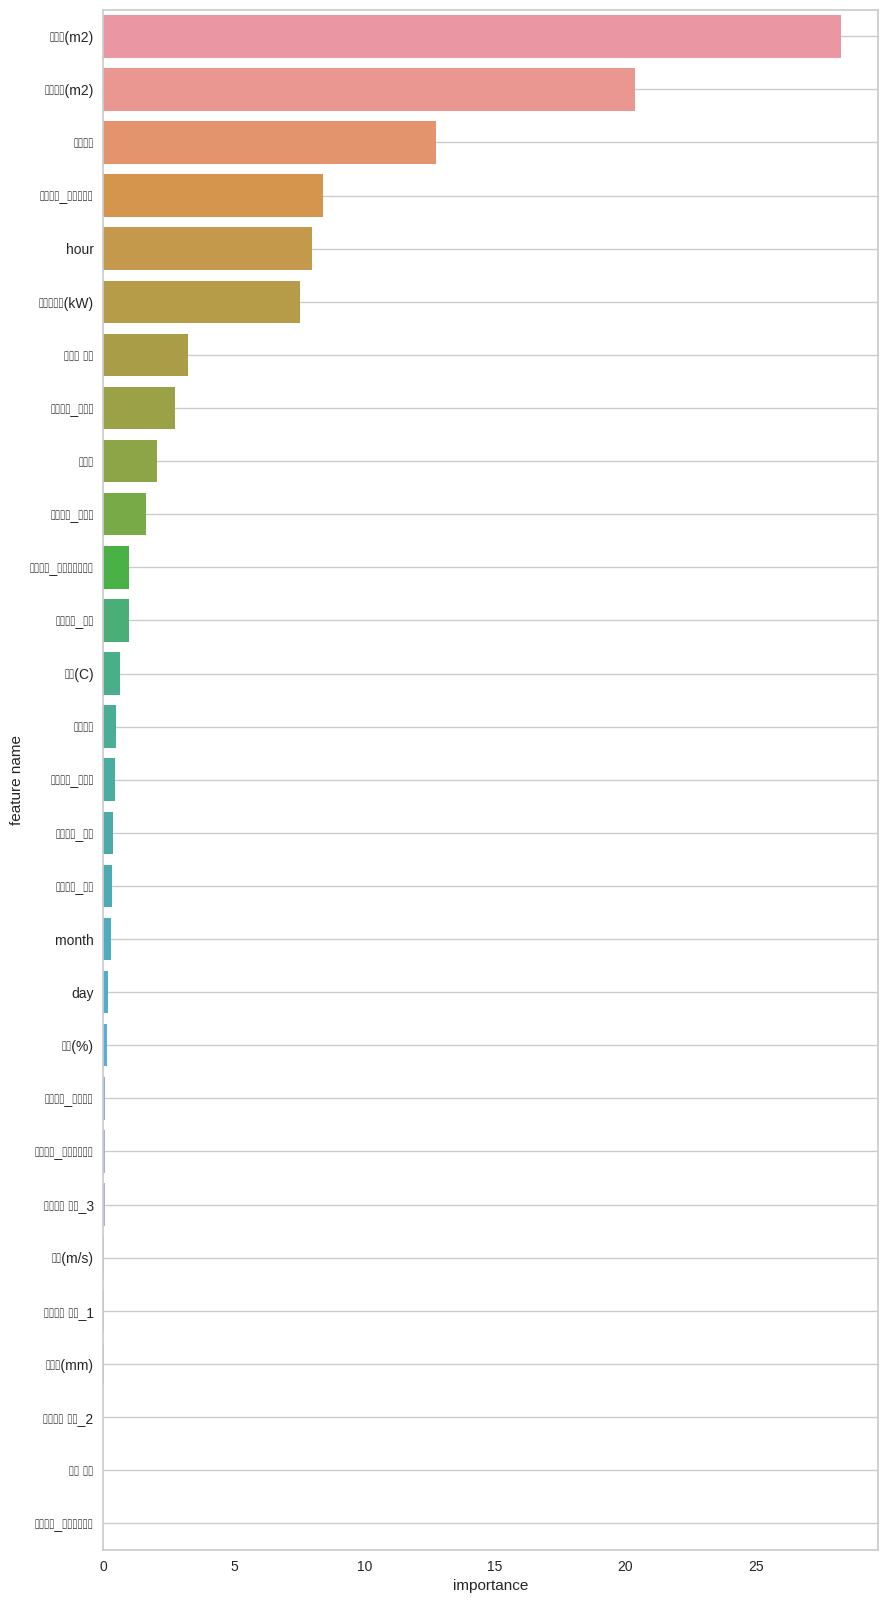

In [ ]:
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

plot_feature_importance(model.feature_importances_,x.columns,result_only = False)

In [ ]:
###########################################################

In [ ]:
train

,기온(C),강수량(mm),풍속(m/s),습도(%),태양광용량(kW),불쾌지수,불쾌지수 단계_1,불쾌지수 단계_2,불쾌지수 단계_3,태양광 유무,강수 유무,전력소비량(kWh),빨간날,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,-2.032448,-0.192615,-1.265495,-2.516713,0.0,-2.476069,0,0,0,0,0,1170.36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-2.201384,-0.192615,-1.090018,-2.300822,0.0,-2.599674,0,0,0,0,0,1146.96,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-2.285852,-0.192615,-0.739065,-2.300822,0.0,-2.673586,0,0,0,0,0,1115.28,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-2.567412,-0.192615,-0.826804,-2.084932,0.0,-2.906815,0,0,0,0,0,1107.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-2.088760,-0.192615,0.401531,-2.444749,0.0,-2.516494,0,0,0,0,0,1069.92,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,-0.089685,-0.192615,0.489270,-1.005479,0.0,-0.365265,1,0,0,0,0,1866.96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2036,-0.230465,-0.192615,0.226055,-0.789588,0.0,-0.444417,1,0,0,0,0,1693.80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2037,-0.343089,-0.192615,-0.914542,-0.717625,0.0,-0.539556,1,0,0,0,0,1564.92,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2038,-0.483869,-0.192615,-0.212636,-0.501734,0.0,-0.627838,1,0,0,0,0,948.96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
test

,기온(C),강수량(mm),풍속(m/s),습도(%),태양광용량(kW),불쾌지수,불쾌지수 단계_1,불쾌지수 단계_2,불쾌지수 단계_3,태양광 유무,강수 유무,빨간날,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0.703128,-0.248065,-0.000698,-0.246328,0.0,0.860970,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.506710,-0.248065,-1.524409,-0.246328,0.0,0.620131,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.388860,-0.248065,-0.821157,-0.049266,0.0,0.553184,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.153159,-0.248065,-1.055575,0.147797,0.0,0.330461,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.035308,-0.248065,-1.407200,0.082109,0.0,0.157288,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.703128,-0.248065,-0.235115,-0.049266,0.0,0.946041,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
164,0.271009,-0.248065,-0.235115,0.279171,0.0,0.530426,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
165,-0.003975,-0.248065,-0.703949,0.344859,0.0,0.198436,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
166,-0.239676,-0.248065,-1.407200,0.476233,0.0,-0.065796,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [15]:
train = train.drop(['태양광용량(kW)','태양광 유무'],axis=1)
test = test.drop(['태양광용량(kW)','태양광 유무'],axis=1)

In [ ]:
train

,기온(C),강수량(mm),풍속(m/s),습도(%),불쾌지수,불쾌지수 단계_1,불쾌지수 단계_2,불쾌지수 단계_3,강수 유무,전력소비량(kWh),빨간날,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,-2.032448,-0.192615,-1.265495,-2.516713,-2.476069,0,0,0,0,1170.36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-2.201384,-0.192615,-1.090018,-2.300822,-2.599674,0,0,0,0,1146.96,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-2.285852,-0.192615,-0.739065,-2.300822,-2.673586,0,0,0,0,1115.28,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-2.567412,-0.192615,-0.826804,-2.084932,-2.906815,0,0,0,0,1107.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-2.088760,-0.192615,0.401531,-2.444749,-2.516494,0,0,0,0,1069.92,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,-0.089685,-0.192615,0.489270,-1.005479,-0.365265,1,0,0,0,1866.96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2036,-0.230465,-0.192615,0.226055,-0.789588,-0.444417,1,0,0,0,1693.80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2037,-0.343089,-0.192615,-0.914542,-0.717625,-0.539556,1,0,0,0,1564.92,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2038,-0.483869,-0.192615,-0.212636,-0.501734,-0.627838,1,0,0,0,948.96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
test

,기온(C),강수량(mm),풍속(m/s),습도(%),불쾌지수,불쾌지수 단계_1,불쾌지수 단계_2,불쾌지수 단계_3,강수 유무,빨간날,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0.703128,-0.248065,-0.000698,-0.246328,0.860970,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.506710,-0.248065,-1.524409,-0.246328,0.620131,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.388860,-0.248065,-0.821157,-0.049266,0.553184,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.153159,-0.248065,-1.055575,0.147797,0.330461,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.035308,-0.248065,-1.407200,0.082109,0.157288,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.703128,-0.248065,-0.235115,-0.049266,0.946041,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
164,0.271009,-0.248065,-0.235115,0.279171,0.530426,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
165,-0.003975,-0.248065,-0.703949,0.344859,0.198436,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
166,-0.239676,-0.248065,-1.407200,0.476233,-0.065796,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
# train.loc[2016:,:]

In [16]:
train['전력소비량'] = train["전력소비량(kWh)"]
train

,기온(C),강수량(mm),풍속(m/s),습도(%),불쾌지수,불쾌지수 단계_1,불쾌지수 단계_2,불쾌지수 단계_3,강수 유무,전력소비량(kWh),빨간날,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,전력소비량
0,-2.032448,-0.192615,-1.265495,-2.516713,-2.476069,0,0,0,0,1170.36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1170.36
1,-2.201384,-0.192615,-1.090018,-2.300822,-2.599674,0,0,0,0,1146.96,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1146.96
2,-2.285852,-0.192615,-0.739065,-2.300822,-2.673586,0,0,0,0,1115.28,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1115.28
3,-2.567412,-0.192615,-0.826804,-2.084932,-2.906815,0,0,0,0,1107.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1107.00
4,-2.088760,-0.192615,0.401531,-2.444749,-2.516494,0,0,0,0,1069.92,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1069.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,-0.089685,-0.192615,0.489270,-1.005479,-0.365265,1,0,0,0,1866.96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1866.96
2036,-0.230465,-0.192615,0.226055,-0.789588,-0.444417,1,0,0,0,1693.80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1693.80
2037,-0.343089,-0.192615,-0.914542,-0.717625,-0.539556,1,0,0,0,1564.92,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1564.92
2038,-0.483869,-0.192615,-0.212636,-0.501734,-0.627838,1,0,0,0,948.96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,948.96


In [17]:
train.loc[2034:,:].drop(['전력소비량(kWh)','전력소비량'],axis=1).shape

(6, 33)

In [18]:
test1 = pd.concat([train.loc[2034:,:].drop(['전력소비량(kWh)','전력소비량'],axis=1),test]).reset_index().drop('index',axis=1)
test1

,기온(C),강수량(mm),풍속(m/s),습도(%),불쾌지수,불쾌지수 단계_1,불쾌지수 단계_2,불쾌지수 단계_3,강수 유무,빨간날,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0.107407,-0.192615,0.138317,-1.005479,-0.168325,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,-0.089685,-0.192615,0.489270,-1.005479,-0.365265,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,-0.230465,-0.192615,0.226055,-0.789588,-0.444417,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,-0.343089,-0.192615,-0.914542,-0.717625,-0.539556,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,-0.483869,-0.192615,-0.212636,-0.501734,-0.627838,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,0.703128,-0.248065,-0.235115,-0.049266,0.946041,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
170,0.271009,-0.248065,-0.235115,0.279171,0.530426,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
171,-0.003975,-0.248065,-0.703949,0.344859,0.198436,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
172,-0.239676,-0.248065,-1.407200,0.476233,-0.065796,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [19]:
train1 = train.loc[:2033,:]
train1 = train1.drop('전력소비량(kWh)',axis=1)
train1

,기온(C),강수량(mm),풍속(m/s),습도(%),불쾌지수,불쾌지수 단계_1,불쾌지수 단계_2,불쾌지수 단계_3,강수 유무,빨간날,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,전력소비량
0,-2.032448,-0.192615,-1.265495,-2.516713,-2.476069,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1170.36
1,-2.201384,-0.192615,-1.090018,-2.300822,-2.599674,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1146.96
2,-2.285852,-0.192615,-0.739065,-2.300822,-2.673586,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1115.28
3,-2.567412,-0.192615,-0.826804,-2.084932,-2.906815,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1107.00
4,-2.088760,-0.192615,0.401531,-2.444749,-2.516494,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1069.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2029,0.501591,-0.192615,0.489270,-1.149406,0.174440,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2039.04
2030,0.360811,-0.192615,-0.826804,-1.077442,0.060298,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2076.48
2031,0.220031,-0.192615,-0.300374,-0.861552,-0.008557,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2199.60
2032,0.135563,-0.192615,0.050579,-0.933515,-0.117158,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2160.72


In [25]:
timestep= 6 #한번에 21주씩 고려하기 (batch?)
x_train_ = train1.drop('전력소비량',axis=1)
y=train1[['전력소비량']]

x = np.array([x_train_[i : i + timestep] for i in range( len(x_train_) - timestep ) ])
y_ = np.array([y.values[i + timestep,-1] for i in range( len(y) - timestep ) ])

x_train, x_val = x[:-24], x[-24:]
y_train, y_val = y_[:-24], y_[-24:]

# x_train = np.expand_dims(x_train, axis=1)
# x_val = np.expand_dims(x_val, axis=1)
# y_train = np.expand_dims(y_train, axis=1)
# y_val = np.expand_dims(y_val, axis=1)



print(x.shape, y_.shape)
print('-------------------------------')
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
# print(x_test.shape, y_test.shape)
print('-------------------------------')
print('[ # , timestep, feature수 ] <-- 데이터의 구조 : ')

(2028, 6, 33) (2028,)
-------------------------------
(2004, 6, 33) (2004,)
(24, 6, 33) (24,)
-------------------------------
[ # , timestep, feature수 ] <-- 데이터의 구조 : 


In [ ]:
y_train[:10]

array([1131.84, 1127.16, 1118.16, 1070.64, 1067.76, 1055.16, 1157.4 ,
       1404.72,  993.24, 1153.8 ])

In [41]:
keras.backend.clear_session()

il = keras.layers.Input(shape=(6,33))
# ll = keras.layers.Conv1D(64,kernel_size=3,activation="relu")(il)
# ll = keras.layers.BatchNormalization()(ll)
ll = keras.layers.LSTM(64, return_sequences=False)(il)
ll = keras.layers.BatchNormalization()(ll)
# ll = keras.layers.GlobalAveragePooling1D()(ll)
# ll = keras.layers.Flatten()(ll)
# ll = keras.layers.BatchNormalization()(ll)
# ll = keras.layers.Dropout(0.2)(ll)
ll = keras.layers.Dense(32,activation="relu")(ll)
ol = keras.layers.Dense(1)(ll)

model = keras.models.Model(il,ol)
model.compile(loss=keras.losses.mean_absolute_percentage_error,metrics=['mse'],optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 33)]           0         
                                                                 
 lstm (LSTM)                 (None, 64)                25088     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 27,457
Trainable params: 27,329
Non-trainable params: 128
_______________________________________________________

In [42]:
es = EarlyStopping(monitor="val_loss",
                   min_delta=0,
                   verbose=1,
                   patience = 9,
                   restore_best_weights = True)
rl = ReduceLROnPlateau(monitor="val_loss",
                       patience=4,
                       factor=0.15,
                       verbose=1,
                       min_lr=0.0000001)

history = model.fit(x_train,y_train,callbacks=[es,rl],epochs=300,verbose=1,validation_data=[x_val,y_val])

Epoch 1/300
63/63 [==============================] - 4s 18ms/step - loss: 99.5531 - mse: 3178644.5000 - val_loss: 99.5826 - val_mse: 2935785.2500 - lr: 0.0010
Epoch 2/300
63/63 [==============================] - 0s 7ms/step - loss: 97.9066 - mse: 3107790.5000 - val_loss: 97.3875 - val_mse: 2833272.7500 - lr: 0.0010
Epoch 3/300
63/63 [==============================] - 1s 9ms/step - loss: 94.6077 - mse: 2969680.0000 - val_loss: 93.0095 - val_mse: 2636989.5000 - lr: 0.0010
Epoch 4/300
63/63 [==============================] - 1s 11ms/step - loss: 89.2247 - mse: 2766949.0000 - val_loss: 86.9625 - val_mse: 2384794.2500 - lr: 0.0010
Epoch 5/300
63/63 [==============================] - 1s 13ms/step - loss: 81.1261 - mse: 2478796.5000 - val_loss: 75.9676 - val_mse: 1963138.3750 - lr: 0.0010
Epoch 6/300
63/63 [==============================] - 1s 12ms/step - loss: 70.2926 - mse: 2097755.5000 - val_loss: 61.2912 - val_mse: 1472307.1250 - lr: 0.0010
Epoch 7/300
63/63 [=============================

In [28]:
# test1
test1 = np.array([test1[i : i + timestep] for i in range( len(test1) - timestep ) ])
# test1.shape

In [43]:
y_pred = model.predict(test1)
y_pred

6/6 [==============================] - 1s 5ms/step


array([[1476.0566 ],
       [1547.2018 ],
       [1628.8242 ],
       [1573.6271 ],
       [1503.0266 ],
       [1366.2666 ],
       [1311.4921 ],
       [1151.8625 ],
       [1765.7969 ],
       [2024.3833 ],
       [2011.6012 ],
       [2033.4312 ],
       [2027.6582 ],
       [2081.0063 ],
       [1930.5087 ],
       [2244.0784 ],
       [2032.5233 ],
       [2039.3367 ],
       [1908.6958 ],
       [1867.9738 ],
       [1683.0491 ],
       [1374.0029 ],
       [1043.4791 ],
       [1318.5188 ],
       [1063.4233 ],
       [1478.742  ],
       [1487.2351 ],
       [1341.2844 ],
       [1235.4761 ],
       [1210.4895 ],
       [1227.7097 ],
       [1204.2983 ],
       [1717.5516 ],
       [1938.4299 ],
       [1987.8718 ],
       [1977.8785 ],
       [2061.0203 ],
       [2088.395  ],
       [2075.662  ],
       [2266.982  ],
       [2215.1614 ],
       [2156.5818 ],
       [1969.6193 ],
       [1810.1877 ],
       [1568.1835 ],
       [1373.8229 ],
       [1059.326  ],
       [1267.

In [ ]:
result_ = []
for i in range(1,101):
    data = pd.read_csv("/content/drive/MyDrive/dacon/train.csv")
    train = gggg(data,building_info)
    train = train.loc[train['건물번호']==i].reset_index().drop('index',axis=1)
    train = pd.get_dummies(train,columns=['건물유형'],drop_first=True)
    train = train.drop(['일시1','건물번호','연면적(m2)','냉방면적(m2)'],axis=1)

    train = pd.get_dummies(train,columns=['hour'],drop_first=True)
    train = train.drop(['month','day'],axis=1)

    firstb = train[["불쾌지수 단계_1", '불쾌지수 단계_2', '불쾌지수 단계_3','태양광 유무','강수 유무','전력소비량(kWh)','빨간날','hour_1',	'hour_2',	'hour_3'	,'hour_4'	,'hour_5'	,'hour_6'	,'hour_7'	,'hour_8'	,'hour_9',	'hour_10'	,'hour_11'	,'hour_12'	,'hour_13'	,'hour_14'	,'hour_15'	,'hour_16',	'hour_17'	,'hour_18'	,'hour_19'	,'hour_20'	,'hour_21'	,'hour_22'	,'hour_23']]
    x_ = train.drop(["불쾌지수 단계_1", '불쾌지수 단계_2', '불쾌지수 단계_3', '전력소비량(kWh)','태양광 유무','강수 유무','빨간날','hour_1',	'hour_2',	'hour_3'	,'hour_4'	,'hour_5'	,'hour_6'	,'hour_7'	,'hour_8'	,'hour_9',	'hour_10'	,'hour_11'	,'hour_12'	,'hour_13'	,'hour_14'	,'hour_15'	,'hour_16',	'hour_17'	,'hour_18'	,'hour_19'	,'hour_20'	,'hour_21'	,'hour_22'	,'hour_23'],axis=1)

    scaler = StandardScaler()
    scaler.fit(x_)

    x_train_ = scaler.transform(x_)
    x_train = pd.DataFrame(x_train_,index=x_.index,columns=x_.columns)
    train = pd.concat([x_train,firstb],axis=1)

    # print(train.shape)

    test = pd.read_csv("/content/drive/MyDrive/dacon/test.csv")
    test = test123(test,building_info)
    test = test.drop(['일시1','건물유형'],axis=1)
    test = test.loc[test['건물번호']==i]
    test = pd.get_dummies(test,columns=['hour'],drop_first=True)
    firstbbb = test[["불쾌지수 단계_1", '불쾌지수 단계_2', '불쾌지수 단계_3','태양광 유무','강수 유무','빨간날','hour_1',	'hour_2',	'hour_3'	,'hour_4'	,'hour_5'	,'hour_6'	,'hour_7'	,'hour_8'	,'hour_9',	'hour_10'	,'hour_11'	,'hour_12'	,'hour_13'	,'hour_14'	,'hour_15'	,'hour_16',	'hour_17'	,'hour_18'	,'hour_19'	,'hour_20'	,'hour_21'	,'hour_22'	,'hour_23']]
    x___ = test.drop(["불쾌지수 단계_1", '불쾌지수 단계_2', '불쾌지수 단계_3','태양광 유무','강수 유무','빨간날','hour_1',	'hour_2',	'hour_3'	,'hour_4'	,'hour_5'	,'hour_6'	,'hour_7'	,'hour_8'	,'hour_9',	'hour_10'	,'hour_11'	,'hour_12'	,'hour_13'	,'hour_14'	,'hour_15'	,'hour_16',	'hour_17'	,'hour_18'	,'hour_19'	,'hour_20'	,'hour_21'	,'hour_22'	,'hour_23'],axis=1)

    scaler1 = StandardScaler()
    scaler1.fit(x___)
    x_test = scaler1.transform(x___)
    x_test = pd.DataFrame(x_test,index=x___.index,columns=x___.columns)
    test = pd.concat([x_test,firstbbb],axis=1)
    test = test.drop(['건물번호','month','day','연면적(m2)','냉방면적(m2)'],axis=1)

    train = train.drop(['태양광용량(kW)','태양광 유무'],axis=1)
    test = test.drop(['태양광용량(kW)','태양광 유무'],axis=1)
    train['전력소비량'] = train["전력소비량(kWh)"]

    # print(train)
    # print(train.loc[2016:,:].drop(['전력소비량(kWh)','전력소비량'],axis=1).shape)

    test1 = pd.concat([train.loc[2016:,:].drop(['전력소비량(kWh)','전력소비량'],axis=1),test]).reset_index().drop('index',axis=1)

    # print(test1.shape)

    train1 = train.loc[:2015,:]
    train1 = train1.drop('전력소비량(kWh)',axis=1)

    # print(train1.shape)

    timestep= 24 #한번에 21주씩 고려하기 (batch?)
    x_train_ = train1.drop('전력소비량',axis=1)
    y=train1[['전력소비량']]

    x = np.array([x_train_[k : k + timestep] for k in range( len(x_train_) - timestep ) ])
    y_ = np.array([y.values[h + timestep,-1] for h in range( len(y) - timestep ) ])

    x_train, x_val = x[:-24], x[-24:]
    y_train, y_val = y_[:-24], y_[-24:]

    keras.backend.clear_session()

    il = keras.layers.Input(shape=(24,33))
    ll = keras.layers.Conv1D(32,kernel_size=5,activation="relu")(il)
    # ll = keras.layers.BatchNormalization()(ll)
    ll = keras.layers.GRU(16, return_sequences=True)(ll)
    ll = keras.layers.BatchNormalization()(ll)
    # ll = keras.layers.GlobalAveragePooling1D()(ll)
    ll = keras.layers.Flatten()(ll)
    # ll = keras.layers.BatchNormalization()(ll)
    # ll = keras.layers.Dropout(0.2)(ll)
    ll = keras.layers.Dense(16,activation="relu")(ll)
    ol = keras.layers.Dense(1)(ll)

    model = keras.models.Model(il,ol)
    model.compile(loss=keras.losses.mean_absolute_percentage_error,metrics=['mse'],optimizer='adam')

    es = EarlyStopping(monitor="val_loss",min_delta=0,verbose=0,patience = 9,restore_best_weights = True)
    rl = ReduceLROnPlateau(monitor="val_loss", patience=4,factor=0.15,verbose=0, min_lr=0.0000001)

    with tf.device("/device:GPU:0"):
        history = model.fit(x_train,y_train,callbacks=[es,rl],epochs=300,verbose=0,validation_data=[x_val,y_val])
    test1 = np.array([test1[g : g + timestep] for g in range( len(test1) - timestep ) ])
    y_pred = model.predict(test1)
    for j in y_pred:
        result_.append(j[0])

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2

In [ ]:
len(result_)

16800

In [ ]:
result(sample_submission,result_)

In [ ]:
result_

[1577.2091,
 1498.1224,
 1403.5237,
 1330.9518,
 1312.592,
 1448.5004,
 1713.4885,
 2157.6921,
 2687.8406,
 3107.911,
 3554.0564,
 3720.3987,
 3874.5388,
 3885.3154,
 3829.2625,
 3809.6243,
 3627.526,
 3240.2505,
 2821.515,
 2687.0159,
 2525.8022,
 2128.9585,
 1610.9391,
 2097.4565,
 2038.2484,
 1893.7009,
 1746.8517,
 1640.672,
 1649.1678,
 1879.995,
 2327.702,
 2785.5916,
 3487.914,
 3782.7869,
 4048.4924,
 4264.802,
 4465.945,
 4505.935,
 4424.2715,
 4377.9766,
 4175.641,
 3703.1367,
 3193.8047,
 2922.987,
 2692.203,
 2083.5405,
 1431.3804,
 1784.2006,
 1728.2175,
 1606.3474,
 1464.0879,
 1367.7429,
 1422.2443,
 1569.3876,
 2085.4407,
 2830.155,
 3607.6614,
 3909.5837,
 4017.3337,
 4048.2483,
 4012.148,
 3947.9954,
 3849.1863,
 3752.0686,
 3658.1504,
 3326.339,
 3082.7075,
 2882.304,
 2704.9963,
 2306.5793,
 1763.0876,
 1764.4625,
 1493.3448,
 1351.8109,
 1167.964,
 1150.952,
 1139.2579,
 1221.9934,
 1432.7819,
 1742.0294,
 2136.8777,
 2555.1858,
 2926.114,
 3161.813,
 3343.1238,
 3

In [ ]:
data.loc[data['전력소비량(kWh)']==0]

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
193120,95_20220727 16,95,20220727 16,29.8,NaN,2.1,51.0,0.9,NaN,0.0
